In [106]:
import requests
import json

symbol = "AAPL"
api_key = "E5Z5NHRB8ZYUI62W"

url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=compact&apikey={api_key}"

response = requests.get(url).json()

print(response)


{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2025-12-05', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-12-05': {'1. open': '280.5400', '2. high': '281.1400', '3. low': '278.0500', '4. close': '278.7800', '5. volume': '47265845'}, '2025-12-04': {'1. open': '284.0950', '2. high': '284.7300', '3. low': '278.5900', '4. close': '280.7000', '5. volume': '43989056'}, '2025-12-03': {'1. open': '286.2000', '2. high': '288.6200', '3. low': '283.3000', '4. close': '284.1500', '5. volume': '43538687'}, '2025-12-02': {'1. open': '283.0000', '2. high': '287.4000', '3. low': '282.6301', '4. close': '286.1900', '5. volume': '53669532'}, '2025-12-01': {'1. open': '278.0100', '2. high': '283.4200', '3. low': '276.1400', '4. close': '283.1000', '5. volume': '46587722'}, '2025-11-28': {'1. open': '277.2600', '2. high': '279.0000', '3. low': '275.9865', '4. close': '278.8500', '5

In [107]:
import requests
import pandas as pd
symbol = "AAPL"
api_key = "E5Z5NHRB8ZYUI62W"

url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=compact&apikey={api_key}"

response = requests.get(url).json()

# Check if key exists
if "Time Series (Daily)" not in response:
    print("Error: API did not return time series data")
    print(response)
else:
    data = response["Time Series (Daily)"]

    # Convert nested dict → DataFrame
    df = pd.DataFrame(data).T

    # Fix date index
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Rename columns
    df.columns = ["Open", "High", "Low", "Close", "Volume"]

    # Convert strings to floats
    df = df.astype(float)

    print("Data loaded successfully:")
    print(df.head())


Data loaded successfully:
              Open    High       Low   Close      Volume
2025-07-17  210.57  211.80  209.5900  210.02  48068141.0
2025-07-18  210.87  211.79  209.7045  211.18  48974591.0
2025-07-21  212.10  215.78  211.6300  212.48  51377434.0
2025-07-22  213.14  214.95  212.2301  214.40  46404072.0
2025-07-23  215.00  215.15  212.4100  214.15  46989301.0


In [108]:
# STEP 2 — Data Cleaning

# Check for missing values
print("Missing values per column:")
print(df.isna().sum())

# Drop rows with missing values (if any)
df = df.dropna()

# Reset index (optional but clean)
df = df.reset_index().rename(columns={"index": "Date"})

print("\nCleaned DataFrame:")
df.head()


Missing values per column:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Cleaned DataFrame:


,Date,Open,High,Low,Close,Volume
0,2025-07-17,210.57,211.80,209.5900,210.02,48068141.0
1,2025-07-18,210.87,211.79,209.7045,211.18,48974591.0
2,2025-07-21,212.10,215.78,211.6300,212.48,51377434.0
3,2025-07-22,213.14,214.95,212.2301,214.40,46404072.0
4,2025-07-23,215.00,215.15,212.4100,214.15,46989301.0


In [109]:
#Add Daily Returns
df["Returns"] = df["Close"].pct_change()


In [110]:
#Add RSI (Relative Strength Index)
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI"] = compute_rsi(df["Close"])


In [111]:
#Add MACD (Trend Indicator)
df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()


In [112]:
#Add Bollinger Bands (Volatility Indicator)
df["BB_Middle"] = df["Close"].rolling(window=20).mean()
df["BB_Std"] = df["Close"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Middle"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Middle"] - (df["BB_Std"] * 2)


In [113]:
#Add Lag Features (Very important for XGBoost)
df["Lag1"] = df["Close"].shift(1)
df["Lag2"] = df["Close"].shift(2)
df["Lag3"] = df["Close"].shift(3)

In [114]:
#Drop rows with NaN created by indicators
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,Returns,RSI,EMA12,EMA26,MACD,Signal,BB_Middle,BB_Std,BB_Upper,BB_Lower,Lag1,Lag2,Lag3
0,2025-08-13,231.070,235.00,230.430,233.33,69878546.0,0.016024,70.338807,220.084628,215.597379,4.487249,1.829087,214.6625,8.964625,232.591749,196.733251,229.65,227.18,229.35
1,2025-08-14,234.055,235.12,230.850,232.78,51916275.0,-0.002357,69.468480,222.037762,216.870165,5.167596,2.496789,215.8005,9.754123,235.308747,196.292253,233.33,229.65,227.18
2,2025-08-15,234.000,234.28,229.335,231.59,56038657.0,-0.005112,67.695722,223.507337,217.960524,5.546813,3.106794,216.8210,10.297793,237.416587,196.225413,232.78,233.33,229.65
3,2025-08-18,231.700,233.12,230.110,230.89,37476188.0,-0.003023,70.661331,224.643131,218.918263,5.724869,3.630409,217.7415,10.704137,239.149774,196.333226,231.59,232.78,233.33
4,2025-08-19,231.275,232.87,229.350,230.56,39402564.0,-0.001429,73.590700,225.553419,219.780613,5.772805,4.058888,218.5495,11.043177,240.635854,196.463146,230.89,231.59,232.78


In [115]:
#Train/Test Split (Time-Based)
from sklearn.model_selection import train_test_split

# Select features (everything except Date and Close)
feature_cols = [
    "Open", "High", "Low", "Volume",
    "Returns", "RSI", "EMA12", "EMA26",
    "MACD", "Signal",
    "BB_Middle", "BB_Std", "BB_Upper", "BB_Lower",
    "Lag1", "Lag2", "Lag3"
]

X = df[feature_cols]
y = df["Close"]

# Time-based split (80% train, 20% test)
split_index = int(len(df) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 64
Testing samples: 17


In [116]:
# Create a time series with Date as index
ts = df.set_index("Date")["Close"]

ts.head()

,Close
Date,
2025-08-13,233.33
2025-08-14,232.78
2025-08-15,231.59
2025-08-18,230.89
2025-08-19,230.56


In [117]:
from statsmodels.tsa.stattools import adfuller #Check Stationarity (Dickey–Fuller Test)

result = adfuller(ts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -0.6564117933330982
p-value: 0.8577192152261803


In [118]:
ts_diff = ts.diff().dropna()#Make Series Stationary

In [119]:
!pip install xgboost joblib --quiet

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings("ignore")

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def print_evaluation(y_true, y_pred, prefix="XGBoost"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} RMSE: {rmse:.4f}")
    print(f"{prefix} MAE : {mae:.4f}")
    print(f"{prefix} MAPE: {mape_val:.4f}%")
    print(f"{prefix} R2  : {r2:.4f}")
    return {"rmse": rmse, "mae": mae, "mape": mape_val, "r2": r2}

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

X_train shape: (64, 17)
X_test  shape: (17, 17)
y_train shape: (64,)
y_test  shape: (17,)


In [130]:
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_base.fit(X_train, y_train)
y_pred_base = xgb_base.predict(X_test)

print("\nBaseline XGBoost evaluation:")
base_metrics = print_evaluation(y_test, y_pred_base, prefix="XGB Baseline")


Baseline XGBoost evaluation:
XGB Baseline RMSE: 5.2858
XGB Baseline MAE : 3.9951
XGB Baseline MAPE: 1.4286%
XGB Baseline R2  : 0.2109


In [122]:
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "learning_rate": [0.001, 0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4, 6, 8],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 1.0],
    "reg_alpha": [0, 0.001, 0.01, 0.1, 1],
    "reg_lambda": [0.5, 1, 2, 5]
}
rs = RandomizedSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=40,               # number of hyperparameter settings to try (adjust if you want)
    scoring="neg_mean_squared_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(rs.best_params_)
print("Best CV score (neg MSE):", rs.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best hyperparameters found:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.001, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1.0}
Best CV score (neg MSE): -56.671427437525246


In [123]:
best_xgb = rs.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

print("Best XGBoost evaluation on test set:")
best_metrics = print_evaluation(y_test, y_pred, prefix="XGB Best")

Best XGBoost evaluation on test set:
XGB Best RMSE: 6.1474
XGB Best MAE : 4.6983
XGB Best MAPE: 1.6781%
XGB Best R2  : -0.0673


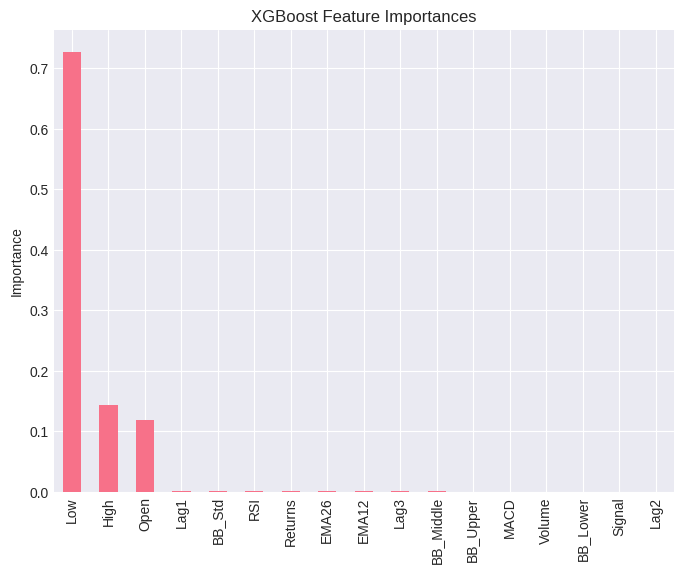


Top features:
 Low        0.727228
High       0.143745
Open       0.118388
Lag1       0.001983
BB_Std     0.001595
RSI        0.001358
Returns    0.001222
EMA26      0.001049
EMA12      0.000751
Lag3       0.000681
dtype: float32


In [124]:
#Feature Importance
try:
    importances = best_xgb.feature_importances_
    feat_names = X_train.columns
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    fi.plot(kind="bar")
    plt.title("XGBoost Feature Importances")
    plt.ylabel("Importance")
    plt.show()
    print("\nTop features:\n", fi.head(10))
except Exception as e:
    print("Feature importance error:", e)

In [125]:
model_path = "xgboost_model_model2.pkl"
preds_path = "xgboost_predictions_model2.csv"

joblib.dump(best_xgb, model_path)
print(f"Saved trained model to: {model_path}")

out = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred
}, index=y_test.index if hasattr(y_test, "index") else None)

out.to_csv(preds_path, index=True)
print(f"Saved test predictions to: {preds_path}")

Saved trained model to: xgboost_model_model2.pkl
Saved test predictions to: xgboost_predictions_model2.csv


In [126]:
summary = {
    "baseline_metrics": base_metrics,
    "best_metrics": best_metrics,
    "best_params": rs.best_params_,
    "model_path": model_path,
    "predictions_csv": preds_path
}
summary

{'baseline_metrics': {'rmse': np.float64(5.285815864120311),
  'mae': 3.995087675206809,
  'mape': np.float64(1.4285553270804048),
  'r2': 0.21088139988015986},
 'best_metrics': {'rmse': np.float64(6.147389965656721),
  'mae': 4.698306382123168,
  'mape': np.float64(1.6780717654427766),
  'r2': -0.06733253454794919},
 'best_params': {'subsample': 0.8,
  'reg_lambda': 2,
  'reg_alpha': 0.001,
  'n_estimators': 800,
  'max_depth': 3,
  'learning_rate': 0.03,
  'colsample_bytree': 1.0},
 'model_path': 'xgboost_model_model2.pkl',
 'predictions_csv': 'xgboost_predictions_model2.csv'}

In [131]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def create_comprehensive_visualizations(y_test, y_pred, model, X_train, X_test,
                                       y_train, y_pred_base=None, base_metrics=None,
                                       best_metrics=None, feature_names=None):
    #create figure with subplots
    fig = plt.figure(figsize=(18, 12))

    #actual vs. predicted
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(y_test.values, label='Actual', marker='o', linewidth=2, markersize=6)
    ax1.plot(y_pred, label='Predicted', linestyle='--', marker='x', linewidth=2, markersize=6)
    ax1.fill_between(range(len(y_test)), y_test.values, y_pred,
                     alpha=0.2, color='gray', label='Error')
    ax1.set_xlabel('Index / Date', fontsize=11)
    ax1.set_ylabel('Close Price ($)', fontsize=11)
    ax1.set_title('XGBoost: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    #add error statistics box
    error_stats = f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}\n" \
                  f"MAE: {mean_absolute_error(y_test, y_pred):.2f}\n" \
                  f"R²: {r2_score(y_test, y_pred):.4f}"
    ax1.text(0.02, 0.98, error_stats, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

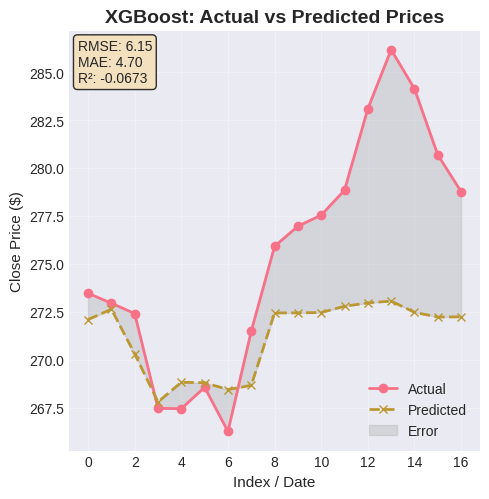

In [132]:
#comprehensive visualizations
create_comprehensive_visualizations(
    y_test=y_test,
    y_pred=y_pred,
    model=best_xgb,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_pred_base=y_pred_base,
    base_metrics=base_metrics,
    best_metrics=best_metrics,
    feature_names=feature_cols
)